### Powerlaw: a Python package for analysis of heavy-tailed distributions

Power-law distributions occur in many situations of scientific interest and have significant consequences for our understanding of natural and man-made phenomena. Unfortunately, the detection and characterization of power laws is complicated by the large fluctuations that occur in the tail of the distribution—the part of the distribution representing large but rare events— and by the difficulty of identifying the range over which power-law behavior holds.

powerlaw is a toolbox using the statistical methods developed in Clauset et al. 2007 and Klaus et al. 2011 to determine if a probability distribution fits a power law.

http://arxiv.org/pdf/1305.0215v3.pdf

Let us start by downloading and installing the package

In [88]:
!pip install powerlaw

### Degree distribution

We must first load the data and use it to create a network using networkx. This way we can use the package to easily calculate the degree of each node.

We do so by implementing the funcion *makeNetworkFromFiles* that returns a graph from files *fedged* and *fnodes*.

In [89]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
import networkx as nx
import pandas as pd
import powerlaw

In [90]:
def makeNetworkFromFiles(fedges, fnodes,deli):
    ''' Generate a network from csv files.
    The first column of the nodes file is taken to be the id by default.
    The nodes file must contain columns named weight, source, and target.
    The deli parameter is the delimeter of the file. '''
    G = nx.Graph()
    fn=pd.read_csv(fnodes,delimiter=deli,index_col=0).transpose()
    n_attr=len(fn.index.values)
    attr=fn.index.values
    for n in fn.columns:
        attr_node=dict(zip(attr, fn[n].values))
        G.add_node(n,attr_dic=attr_node)
    fl=pd.read_csv(fedges,delimiter=deli)
    fl.columns = map(str.lower, fl.columns)
    for L in fl.index.values:
        G.add_edge(fl['source'][L],fl['target'][L],weight=fl['weight'][L])
    GL = max(nx.connected_component_subgraphs(G), key=len)
    return GL

## You can **choose from three different data sets** by commenting on the other two. At this point you can also select whether you want the **degree to be weighted or not**

In [91]:
G= makeNetworkFromFiles('Air_Data [Edges].csv', 'Air_Data [Nodes].csv',',')
#G= makeNetworkFromFiles('SchoolEdges.csv', 'SchoolNodes.csv',' ')
#G= makeNetworkFromFiles('USCommuting_LINKS.csv', 'USCommuting_NODES.csv',' ')

k_vec=dict(G.degree()).values()
#k_vec=G.degree(weight='weight').values()

Now that we have the vector of degrees, we can use the powerlaw package. First of all we plot the pdf of the degree distribution. Plotting a pdf requires in general the binning of the data, moreover when presenting the pdf using logarithmic axis the bins must have a logarithmic spacing. 

The logarithmic binning is particularly usefull when fitting a powerlaw to the data, since observing the occurrences becomes less and less likely as the variable increases.

To illustrate this point we show the pdf of the degree of the previously chosen data, using linear and logarithmic binnings. Note what happens for large values of the variable in the linear binning.

Text(0.5,1,u'Comp. Cummulative Degree Distribution')

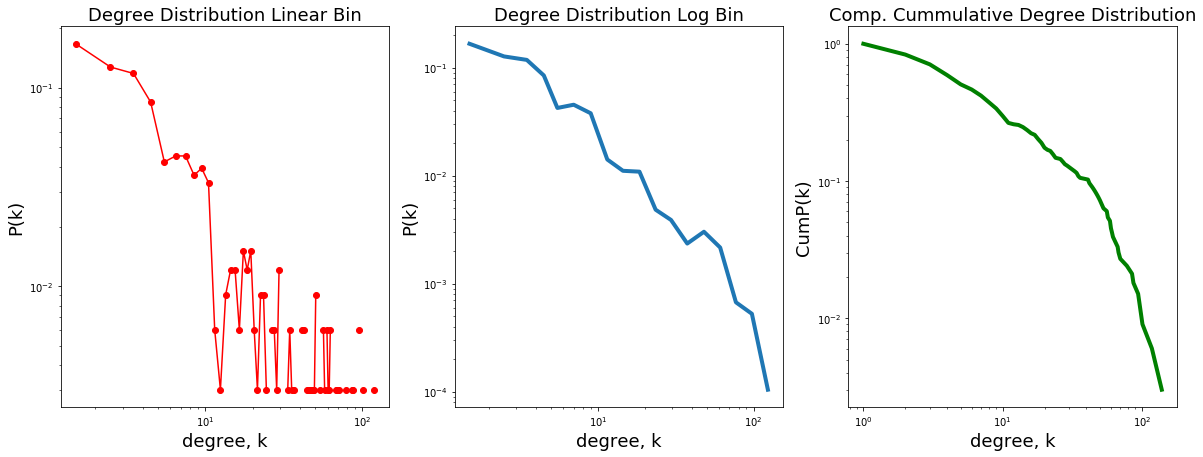

In [92]:
plt.figure(figsize=(20,7))
plt.subplot(131)
powerlaw.plot_pdf(k_vec,color ='r',marker= 'o',linear_bins=True)
plt.ylabel('P(k)',fontsize=18)
plt.xlabel('degree, k',fontsize=18)
plt.title('Degree Distribution Linear Bin',fontsize=18)
plt.subplot(132)
powerlaw.plot_pdf(k_vec,linewidth=4)
plt.ylabel('P(k)',fontsize=18)
plt.xlabel('degree, k',fontsize=18)
plt.title('Degree Distribution Log Bin',fontsize=18)
plt.subplot(133)
powerlaw.plot_ccdf(k_vec,linewidth=4,color ='g')
plt.ylabel('CumP(k)',fontsize=18)
plt.xlabel('degree, k',fontsize=18)
plt.title('Comp. Cummulative Degree Distribution',fontsize=18)

### Fitting a powerlaw using *powerlaw*

To fit a powerlaw on the data we use the method *powerlaw.Fit*. The result is an object that contains the maximum likelihood fit to the given data.

The most importat input parameters are the following:
* data : list or array
* discrete : boolean, optional
    -Whether the data is discrete (integers).
* xmin : int or float, optional
    -The data value beyond which distributions should be fitted. If None an optimal one will be calculated.
* xmax : int or float, optional
    -The maximum value of the fitted distributions.
    
In our case our data is *k_vec*, which is **discrete if your chose to work with a unweighted network, and is continuous otherwise**.

In [93]:
fit=powerlaw.Fit(k_vec,discrete=True)

Calculating best minimal value for power law fit


The *fit.power_law* object is the one we are interested in. We can access the value of $\alpha$ and the value of the standard error of the fit. We can also access the estimated optimum *xmin*, from where the distribution starts to behave as a powerlaw.

In [94]:
print 'alpha =',fit.power_law.alpha   #exponent of the power law
print 'standard error =',fit.power_law.sigma  #standard error oof the fit
print 'xmin =',fit.xmin #xmin

alpha = 1.8183051557194518
standard error = 0.06313361340938134
xmin = 5.0


The *fit.power_law* object we have created contains the same plotting options that we saw before. It will allow us to plot the pdf of the raw data, and of the powelaw fit.

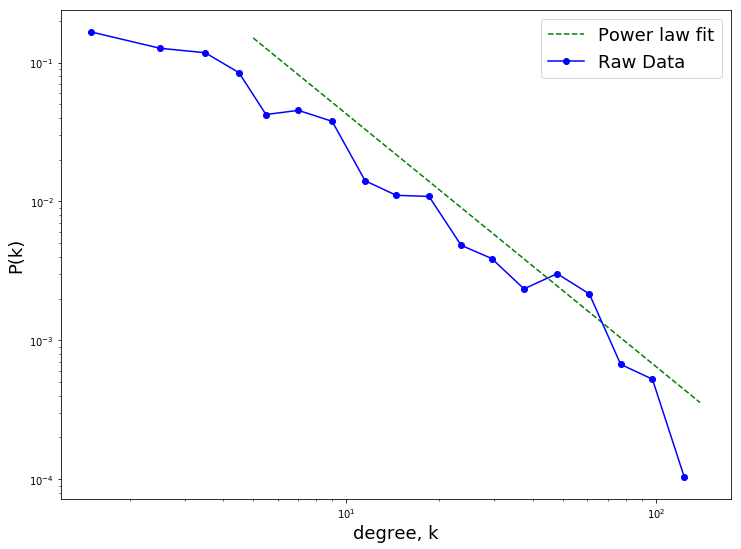

In [99]:
plt.figure(figsize=(12,9))
fit.power_law.plot_pdf(color='g',linestyle='--',label='Power law fit')
powerlaw.plot_pdf(k_vec,color ='b',marker= 'o',label='Raw Data')
plt.ylabel('P(k)',fontsize=18)
plt.xlabel('degree, k',fontsize=18)
plt.legend(loc='best',fontsize=18)

### Testing the Fit

* Fitting of other distributions such as *exponential* or *lognormal* that are usefull for testig whether a powerlaw is the best fit for the observed data.
* Generating a sample from the model.
* Restricting the parameter range.

For example, the school dataset is best fit by a lognormal distribution.

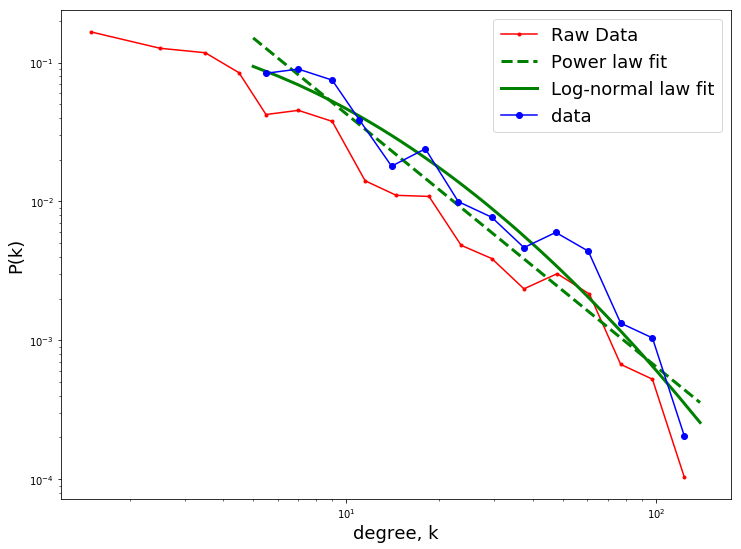

In [96]:
plt.figure(figsize=(12,9))
powerlaw.plot_pdf(k_vec,color ='r',marker= '.',label='Raw Data')
fit.power_law.plot_pdf(color='g',linestyle='--',linewidth=3,label='Power law fit')
fit.lognormal.plot_pdf(color='g',linestyle='-',linewidth=3,label='Log-normal law fit')
fit.plot_pdf(color='b',marker='o',label='data')
plt.ylabel('P(k)',fontsize=18)
plt.xlabel('degree, k',fontsize=18)
plt.legend(loc='best',fontsize=18)

In [97]:
fit.distribution_compare('power_law','lognormal')

(-11.758024528734161, 0.0010047095108967293)

## the lognormal gives better fit than powerlaw

## Instead of letting the library select the minimun degree we can fix it from the data

In [72]:
min(k_vec)

1

In [74]:
fit=powerlaw.Fit(k_vec,xmin=1,discrete=True)
print 'alpha =',fit.power_law.alpha   #exponent of the power law
print 'standard error =',fit.power_law.sigma  #standard error oof the fit
print 'xmin =',fit.xmin #xmin

alpha = 1.4155784049319693
standard error = 0.022807828042526745
xmin = 1.0


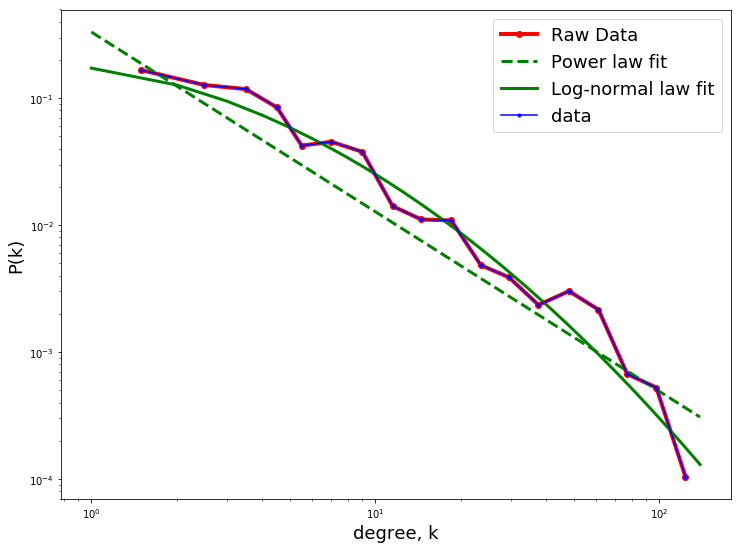

In [81]:
plt.figure(figsize=(12,9))
powerlaw.plot_pdf(k_vec,color ='r',marker= 'o',linewidth=4,label='Raw Data')
fit.power_law.plot_pdf(color='g',linestyle='--',linewidth=3,label='Power law fit')
fit.lognormal.plot_pdf(color='g',linestyle='-',linewidth=3,label='Log-normal law fit')
fit.plot_pdf(color='b',marker='.',label='data')
plt.ylabel('P(k)',fontsize=18)
plt.xlabel('degree, k',fontsize=18)
plt.legend(loc='best',fontsize=18)

In [84]:
fit.distribution_compare('power_law','lognormal')

(-68.92155146231414, 3.4084305308312877e-16)

## Taking into account the entire data the lognormal is a better fit.